# Strong Lensing Challenge - Multi-Class Classification 

Gravitational lensing has been a cornerstone in many cosmology experiments and studies since it was discussed in Einstein’s calculations back in 1936 and discovered in 1979, and one area of particular interest is the study of dark matter via substructure in strong lensing images. In this challenge, we focus on exploring the potential of supervised models in identifying dark matter based on simulated strong lensing images with different substructure.

This is an example notebook for the Multi-Class Classification Challenge. In this notebook, we demonstrate a simple CNN model implemented using the PyTorch library to solve the task of multi-class classification of strong lensing images.

### Dataset

The Dataset consists of three classes, strong lensing images with no substructure, spherical substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

Link to the Dataset: https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view?usp=sharing

### Evaluation Metrics

* ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)   

The model performance will be tested on the hidden test dataset based on the above metrics.

### Instructions for using the notebook

1. Use GPU acceleration: (Edit --> Notebook settings --> Hardware accelerator --> GPU)
2. Run the cells: (Runtime --> Run all)

In [1]:
# Download Dataset
!gdown http://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
!unzip -q dataset.zip

Downloading...
From: http://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
To: /content/dataset.zip
100% 1.13G/1.13G [00:06<00:00, 177MB/s]


## Multi-Class Classification using a Supervised Model

### 1. Data Visualization and Preprocessing 

#### 1.1 Import all the necessary libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import models
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
%matplotlib inline

#### 1.2 Preview the Data

Samples with no substructure: 


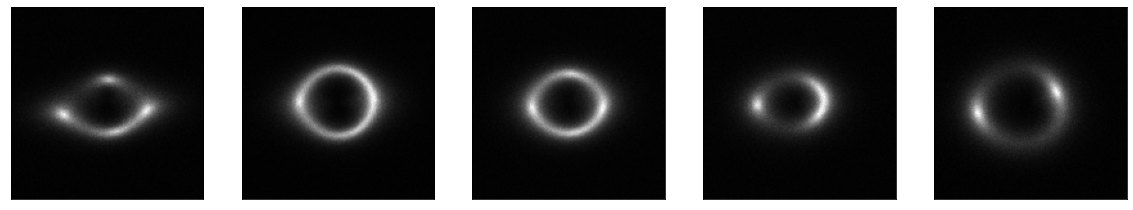

Samples with spherical substructure: 


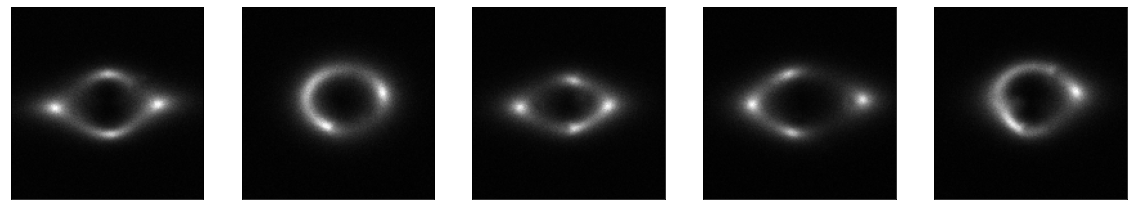

Samples with vortex substructure: 


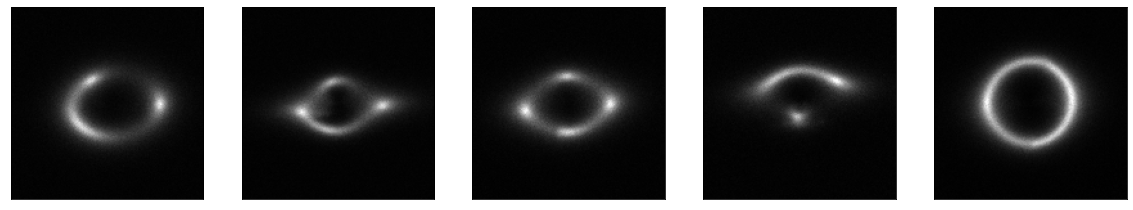

In [3]:
# Define the input paths
train_path1 = './dataset/train/no'
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]
train_path2 = './dataset/train/sphere'
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]
train_path3 = './dataset/train/vort'
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plot the samples 
i = 1
print('Samples with no substructure: ')
plt.rcParams['figure.figsize'] = [20, 20]
for image in train_files1[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with spherical substructure: ')
plt.rcParams['figure.figsize'] = [20, 20]
for image in train_files2[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with vortex substructure: ')
plt.rcParams['figure.figsize'] = [20, 20]
for image in train_files3[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

#### 1.3 Import Training and Validation Data

In [4]:
# Set Batch Size
batch_size = 100

# Define Data Loaders
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

train_data = torchvision.datasets.DatasetFolder(root='./dataset/train', loader=npy_loader, extensions='.npy')
print("Training Classes: " + str(train_data.class_to_idx))
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

val_data = torchvision.datasets.DatasetFolder(root='./dataset/val', loader=npy_loader, extensions='.npy')
print("Validation Classes: " + str(val_data.class_to_idx))
val_data_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 2. Training

#### 2.1 Defining a CNN Model

You may refer to this [article](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148) to learn about Convolutional Neural Networks (CNN)

In [5]:
# Define the Model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 5, stride = 2, padding = 0)
    self.resnet = models.resnet50(pretrained=True)
    self.linear1 = nn.Linear(1000, 84)
    self.linear2 = nn.Linear(84, 3)

  def forward(self, x):
    x = self.conv1(x)
    x = self.resnet(x)
    x = self.linear1(x)
    x = self.linear2(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#### 2.2 Training the CNN Model

In [6]:
# Loss Function
criteria = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Calculate the number of batches
n_batches_train = (len(train_files1)*3)/batch_size

# Train the model
n_epochs = 30 # Number of Training Epochs
loss_array = []
pbar = tqdm(range(1, n_epochs+1))
for epoch in pbar:
    train_loss = 0.0
    train_acc = 0.0

    for step, (x_tr, y_tr) in enumerate(train_data_loader):
        data = Variable(x_tr).type(torch.cuda.FloatTensor)
        
        if torch.cuda.is_available():
          data = data.cuda()

        labels = torch.tensor(y_tr, dtype=torch.long, device=device)
        optimizer.zero_grad()
        outputs = model(data)
        _, preds = torch.max(model(data).data, 1)
        correct = (preds == labels).float().sum()
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss
        train_acc += correct/data.shape[0] 

    train_loss = train_loss / n_batches_train
    train_acc = train_acc / n_batches_train
    # Display the Training Stats
    pbar.set_postfix({ 'Training Loss': train_loss.item(), 'Training Acc': train_acc.item() })

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### 3. Testing

#### 3.1 Testing the CNN Model on Validation Data

In [7]:
y_score = []
y_test = []

for _, (x_ts, y_ts) in enumerate(val_data_loader):

    mini_val_data = Variable(x_ts).type(torch.cuda.FloatTensor)
    if torch.cuda.is_available():
      mini_val_data = mini_val_data.cuda()
    y_score.append(torch.nn.functional.softmax(model(mini_val_data), dim=1).cpu().detach().numpy())
    y_test.append(y_ts.cpu().detach().numpy())

y_score = np.asarray(y_score).reshape(-1,3)
y_val = np.asarray(y_test).reshape(-1)
y_val = label_binarize(y_val, classes=[0, 1, 2])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
y_val

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [9]:
y_score

array([[6.8215483e-01, 1.2581566e-01, 1.9202952e-01],
       [9.9422497e-01, 5.7724537e-03, 2.5848972e-06],
       [9.2620182e-01, 1.8472558e-02, 5.5325605e-02],
       ...,
       [8.9130348e-01, 8.0810681e-02, 2.7885854e-02],
       [2.8877283e-05, 9.7816819e-01, 2.1802913e-02],
       [4.7757703e-10, 8.6894943e-08, 9.9999988e-01]], dtype=float32)

#### 3.2 Plotting the ROC Curve

You may refer to this [article](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) to learn about the ROC Curve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


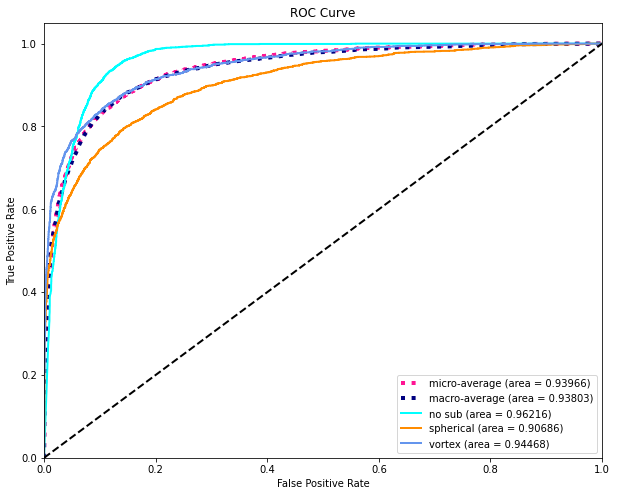

In [10]:
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [10, 8]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))


# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})


#### Saving Model

In [12]:
torch.save(model.state_dict(), 'model')